In [1]:
import glob
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import time

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models, utils

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [2]:
test_csv = os.path.join('data','training-dataset','latest_training_data.csv')
df_test = pd.read_csv(test_csv)
df_test.head()

,image_id,label
0,BreastHistoTTD_1029,1
1,BreastHistoTTD_1035,1
2,BreastHistoTTD_389,1
3,BreastHistoTTD_1086,1
4,BreastHistoTTD_411,1


In [3]:
df_test['image_path'] = df_test['image_id'].map(lambda x: os.path.join('data','training-dataset','latest_training_data1',x+'.png'))
df_test.head()

,image_id,label,image_path
0,BreastHistoTTD_1029,1,data\training-dataset\latest_training_data1\Br...
1,BreastHistoTTD_1035,1,data\training-dataset\latest_training_data1\Br...
2,BreastHistoTTD_389,1,data\training-dataset\latest_training_data1\Br...
3,BreastHistoTTD_1086,1,data\training-dataset\latest_training_data1\Br...
4,BreastHistoTTD_411,1,data\training-dataset\latest_training_data1\Br...


In [17]:
df_test = df_test.iloc[:200]

df_test.shape

(200, 4)

In [5]:
df_test.head()

,image_id,label,image_path
0,BreastHistoTTD_1029,1,data\training-dataset\latest_training_data1\Br...
1,BreastHistoTTD_1035,1,data\training-dataset\latest_training_data1\Br...
2,BreastHistoTTD_389,1,data\training-dataset\latest_training_data1\Br...
3,BreastHistoTTD_1086,1,data\training-dataset\latest_training_data1\Br...
4,BreastHistoTTD_411,1,data\training-dataset\latest_training_data1\Br...


In [6]:
class GenomeDataset(Dataset):
    def __init__(self, df, transform = None, training=True):
        self.df = df
        self.len = len(self.df)
        self.transform = transform
        self.training = training
        self.normalize = transforms.Normalize(
                         mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]
                      )
        self.toTensor = transforms.Compose([transforms.ToTensor(), self.normalize])
        
    def __len__(self):
        return self.len
    
    def get_random_number(self):
        return random.randint(0,self.len-1)
    
    def __getitem__(self,idx):
        img = Image.open(self.df.iloc[idx].loc['image_path'])
        
        if self.transform:
            img = self.transform(img)
            
        img = self.toTensor(img)
            
        if self.training:    
            label = self.df.iloc[idx].loc['label']
            return img,  label
        else:
            return img

In [18]:
# normalize = transforms.Normalize(
#    mean=[0.5, 0.5, 0.5],
#    std=[0.5, 0.5, 0.5]
# )

# trans_train = transforms.Compose([
#     transforms.Resize([224,224]),
# #     transforms.Pad(64, padding_mode='reflect'),
#     transforms.RandomHorizontalFlip(),   
#     transforms.RandomVerticalFlip(),   
#     transforms.RandomRotation(20),
# #     transforms.RandomCrop(224),
#     transforms.ToTensor(),
#     normalize
# ])

trans_test = transforms.Compose([
    transforms.Resize([224,224]),
#     transforms.ToTensor(),
#     normalize
])

# train_ds = GenomeDataset(df_train, transform=imgaug_transforms)
# val_ds = GenomeDataset(df_val, transform=trans_test)
test_ds = GenomeDataset(df_test, transform=trans_test, training=False)

# train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
# val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=32, num_workers=0)

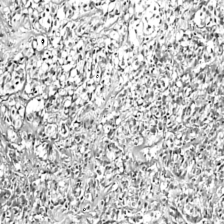

In [19]:
toPIL = transforms.ToPILImage()
toPIL(test_ds[3][0])

In [20]:
model = models.densenet161(pretrained=False)

num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 2)
        )

model = model.to(device)

In [21]:
model_path = os.path.join('model','densenet_100.pth')

model.load_state_dict(torch.load(model_path))

In [22]:
def predict():
    model.eval()  
    y_pred=[]

    with torch.no_grad():
        correct = 0
        total = 0
        for images in test_dl:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_pred+=list(predicted.cpu().numpy())
    return y_pred


In [23]:
start_time = time.time()
predictions = predict()
print('Prediction time: {:10f} minutes'.format((time.time()-start_time)/60))

Prediction time:   1.265051 minutes


In [24]:
df_test['Classification'] = pd.Series(predictions)

In [25]:
df_test.head()

,image_id,label,image_path,Classification
0,BreastHistoTTD_1029,1,data\training-dataset\latest_training_data1\Br...,1
1,BreastHistoTTD_1035,1,data\training-dataset\latest_training_data1\Br...,1
2,BreastHistoTTD_389,1,data\training-dataset\latest_training_data1\Br...,1
3,BreastHistoTTD_1086,1,data\training-dataset\latest_training_data1\Br...,1
4,BreastHistoTTD_411,1,data\training-dataset\latest_training_data1\Br...,1


In [26]:
(df_test['label'] == df_test['Classification']).sum()/len(df_test)

1.0